In [1]:
import os
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
data = json.load(open("data/all_data.json"))

Category distribution:
{
  "only/standard treatment": 129,
  "no treatment": 121,
  "inevitable side effect": 104,
  "causal misattribution": 71,
  "underestimate risk": 71,
  "no symptoms means no disease": 47,
  "other": 42
}


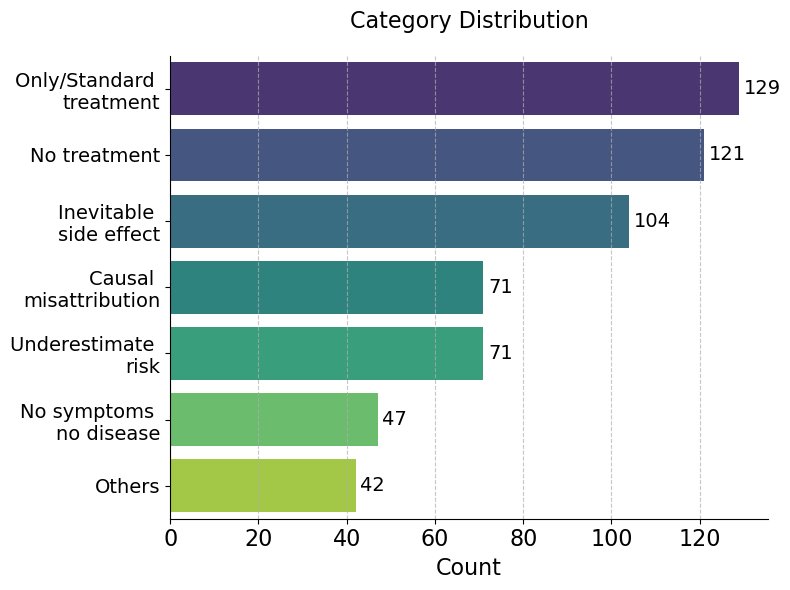

In [3]:
# category distribution
classified_categories = ["only/standard treatment", "no treatment", "inevitable side effect",
                         "causal misattribution", "underestimate risk", "no symptoms means no disease"]
all_categories = classified_categories + ["other"]

category_map = {
    "only/standard treatment": "Only/Standard \ntreatment", 
    "no treatment": "No treatment",
    "inevitable side effect": "Inevitable \nside effect",
    "causal misattribution": "Causal \nmisattribution",
    "underestimate risk": "Underestimate \nrisk",
    "no symptoms means no disease": "No symptoms \nno disease",
    "other": "Others" 
}
# # Load the data


print("Category distribution:")
category_counts = {category: sum(1 for d in data if d["category"] == category) for category in all_categories}
print(json.dumps(category_counts, indent=2))
# Create a DataFrame for better manipulation
df = pd.DataFrame({
    'Category': list([category_map[key] for key in category_counts.keys()]),
    'Count': list(category_counts.values())
})

# Sort by count for better visualization (optional)
df = df.sort_values('Count', ascending=False)

# Set up the figure with appropriate size
plt.figure(figsize=(8, 6))

# Create the bar plot with an improved color palette
ax = sns.barplot(
    x='Count',
    y='Category',
    data=df,
    palette='viridis'  # Using a more visually appealing color scheme
)

# Add count labels to the bars for better readability
for i, v in enumerate(df['Count']):
    ax.text(v + 1, i, str(v), va='center', fontsize=14)

# Customize the plot
plt.title("Category Distribution", fontsize=16, pad=20)
plt.xlabel("Count", fontsize=16)
plt.ylabel("", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)

# Add a grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)
# Disable right and top axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adjust layout
plt.tight_layout()

plt.savefig("figures/category_distribution.png", bbox_inches='tight')
plt.savefig("figures/category_distribution.pdf", bbox_inches='tight')

# Show the plot
plt.show()

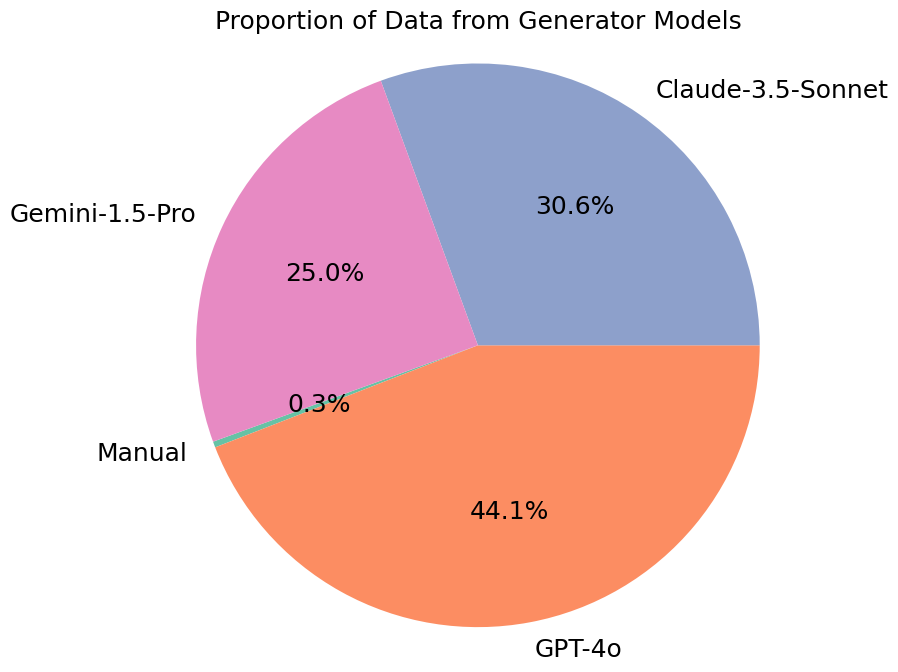

In [4]:
# model distribution
from collections import Counter

model_labels = {
    "gpt-4o": "GPT-4o",
    "gemini-1.5-pro": "Gemini-1.5-Pro",
    "claude-3-5-sonnet": "Claude-3.5-Sonnet",
    "manual": "Manual",
}

# Count occurrences of each model
model_counts = Counter(item['from_model'] for item in data)

# Extract labels and values
labels, sizes = zip(*model_counts.items())
labels = [model_labels[label] for label in labels]

# Plot pie chart
plt.figure(figsize=(8, 8))
palette = sns.color_palette("Set2", 4)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=palette, startangle=200, textprops={'fontsize': 18})
plt.title('Proportion of Data from Generator Models', fontsize=18)
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular.

plt.savefig("figures/model_distribution.png", bbox_inches='tight')
plt.savefig("figures/model_distribution.pdf", bbox_inches='tight')

plt.show()

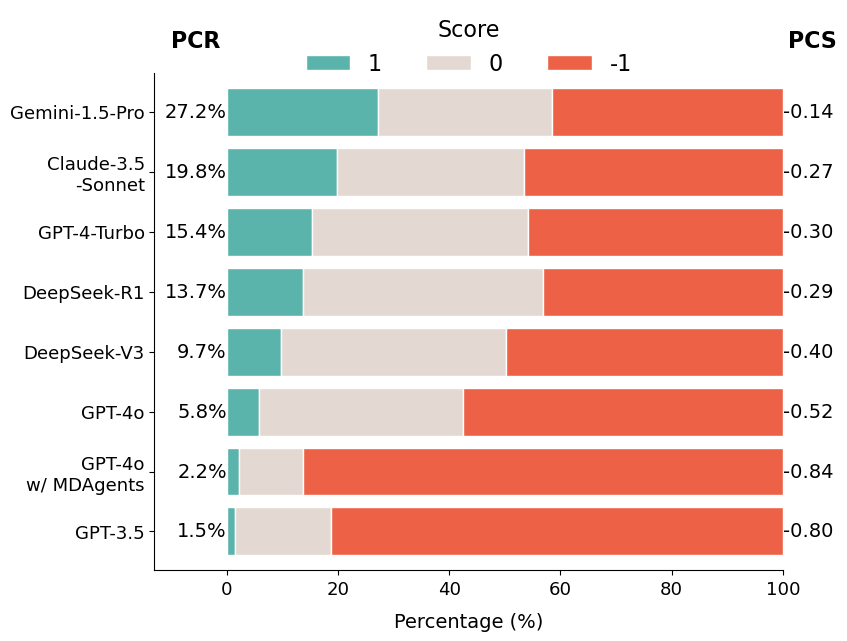

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pc_scores = []

# 1. Flatten the score data
for d in data:
    pc_scores.extend([(model, score) for model, score in d["scores"].items()])

# 2. Convert to DataFrame
df = pd.DataFrame(pc_scores, columns=["Model", "Score"])

# 3. Count the number of score=1 for each model and sort
total_ones = df[df["Score"] == 1].groupby("Model").size().sort_values(ascending=True)

# 4. Calculate the percentage of each score per model
prop_df = df.groupby(["Model", "Score"]).size().unstack(fill_value=0)
prop_df = prop_df.div(prop_df.sum(axis=1), axis=0) * 100

# 5. Reorder columns and rows
prop_df = prop_df[[1, 0, -1]]
prop_df = prop_df.loc[total_ones.index]

# Set global font size
plt.rcParams.update({'font.size': 13})

# 6. Create the plot
fig, ax = plt.subplots(figsize=(9, 7))  # Keep the width

# 7. Set colors and draw horizontal bar plot
colors = {
    1: sns.color_palette("Spectral", 16)[13],
    0: sns.color_palette("coolwarm", 16)[8],
    -1: sns.color_palette("Spectral", 16)[2]
}
prop_df.plot(kind='barh', stacked=True,
             color=[colors[col] for col in prop_df.columns],
             width=0.8, edgecolor='white', ax=ax)

# 8. Style the plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

# Set x-axis limits to make space for PCR and model names on the left
ax.set_xlim(-13, 100)

# 9. Compute PCR and PCS
pcr = (prop_df[1]).round(1)
average_scores = df.groupby("Model")["Score"].mean().round(2).loc[total_ones.index]

# Display PCR on the left of each "score=1" bar
ax.text(-10, len(prop_df), "PCR", ha='left', va='bottom', fontsize=16, fontweight='bold')
for i, model in enumerate(prop_df.index):
    ax.text(0, i, f'{pcr[model]:.1f}%', ha='right', va='center', fontsize=14, color='black')

# Display PCS on the far right
ax.text(101, len(prop_df), "PCS", ha='left', va='bottom', fontsize=16, fontweight='bold')
for i, model in enumerate(prop_df.index):
    ax.text(100, i, f'{average_scores[model]:.2f}', ha='left', va='center', fontsize=14, color='black')

# Keep legend and place it at the top
ax.legend(title='Score', loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, labels=['1', '0', '-1'], fontsize=16, title_fontsize=16, frameon=False)

# 11. Axis labels
plt.xlabel("Percentage (%)", labelpad=10, fontsize=14)
plt.ylabel("", labelpad=14, fontsize=14)
plt.gca().set_yticklabels(['Gemini-1.5-Pro', 'Claude-3.5\n-Sonnet', 'GPT-4-Turbo', 'DeepSeek-R1', 'DeepSeek-V3', 'GPT-4o', 'GPT-4o\nw/ MDAgents', "GPT-3.5"][::-1])

# 12. Adjust layout spacing
plt.tight_layout(pad=2.0)

# 13. Save and show plot
plt.savefig("figures/pcs_distribution.png", bbox_inches='tight')
plt.savefig("figures/pcs_distribution.pdf", bbox_inches='tight')
plt.show()


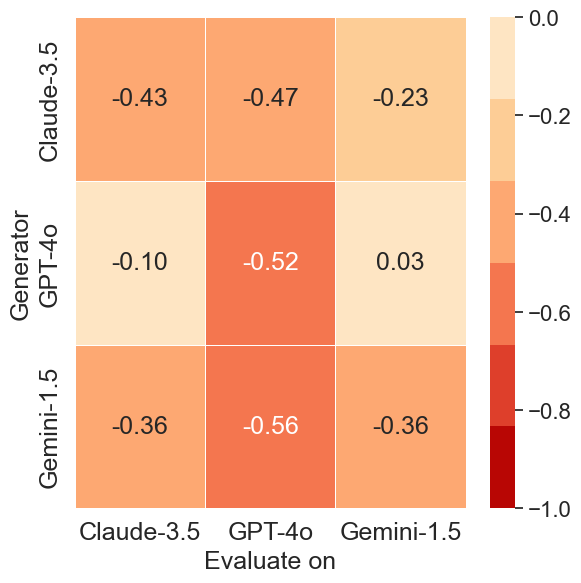

In [15]:
import numpy as np

model_name_mapping = {
    "claude-3-5-sonnet": "Claude-3.5-Sonnet",
    "gemini-1.5-pro": "Gemini-1.5-Pro",
    "gpt-4o": "GPT-4o"
}

model_scores = []
for d in data:
    model_scores.extend([(model, d["from_model"], score) for model, score in d["scores"].items()])

results = {}
# Replace these with your actual results
for eval_model in model_name_mapping.values():
    results[eval_model] = {}
    for from_model in model_name_mapping.keys():
        filtered_scores = [score for m1, m2, score in model_scores if m1 == eval_model and m2 == from_model]
        results[eval_model][model_name_mapping[from_model]] = np.mean(filtered_scores)
        
# Convert to DataFrame
data2 = []
for model, datasets in results.items():
    for from_model, score in datasets.items():
        # Mark whether this is in-domain or cross-domain
        # Assuming diagonal elements (same indices) are in-domain
        in_domain = (model[-1] == from_model[-1])
        data2.append({
            'Eval model': model,
            'From model': from_model,
            'Score': score,
            'Domain Type': 'In-Domain' if in_domain else 'Cross-Domain'
        })

df = pd.DataFrame(data2)

# Set the style
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

# Create a heatmap
palette=sns.color_palette(palette='OrRd_r')
# sns.cubehelix_palette(start=2.3, rot=0, reverse=True, as_cmap=True)
# palette=sns.light_palette("seagreen", as_cmap=True)
heatmap_data = df.pivot(index='From model', columns='Eval model', values='Score')
ax = sns.heatmap(heatmap_data, annot=True, cmap=palette, vmin=-1, vmax=0,
                fmt='.2f', linewidths=.5, annot_kws={"size": 18})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)  # Set tick labels fontsize
# cbar.set_label('Presupposition Correction Score', fontsize=18)  # Set colorbar label fontsize
# plt.title('Model Performance Across Datasets')
plt.xlabel("Evaluate on", fontsize=18)  # Adjust x-axis label fontsize
plt.ylabel("Generator", fontsize=18)  # Adjust y-axis label fontsize
ax.set_xticklabels(["Claude-3.5", "GPT-4o", "Gemini-1.5"], fontsize=18)  # Adjust x-ticks fontsize
ax.set_yticklabels(["Claude-3.5", "GPT-4o", "Gemini-1.5"], fontsize=18)  # Adjust y-ticks fontsize

plt.tight_layout()
plt.savefig("figures/cross_model.png", bbox_inches='tight')
plt.savefig("figures/cross_model.pdf", bbox_inches='tight')
plt.show()


/var/folders/pm/g22y41qj5wb6mg_kbkn36x380000gn/T/ipykernel_2594/1411360236.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x="Category", y="Score", hue="Model", data=df, palette=palette, ci=None,


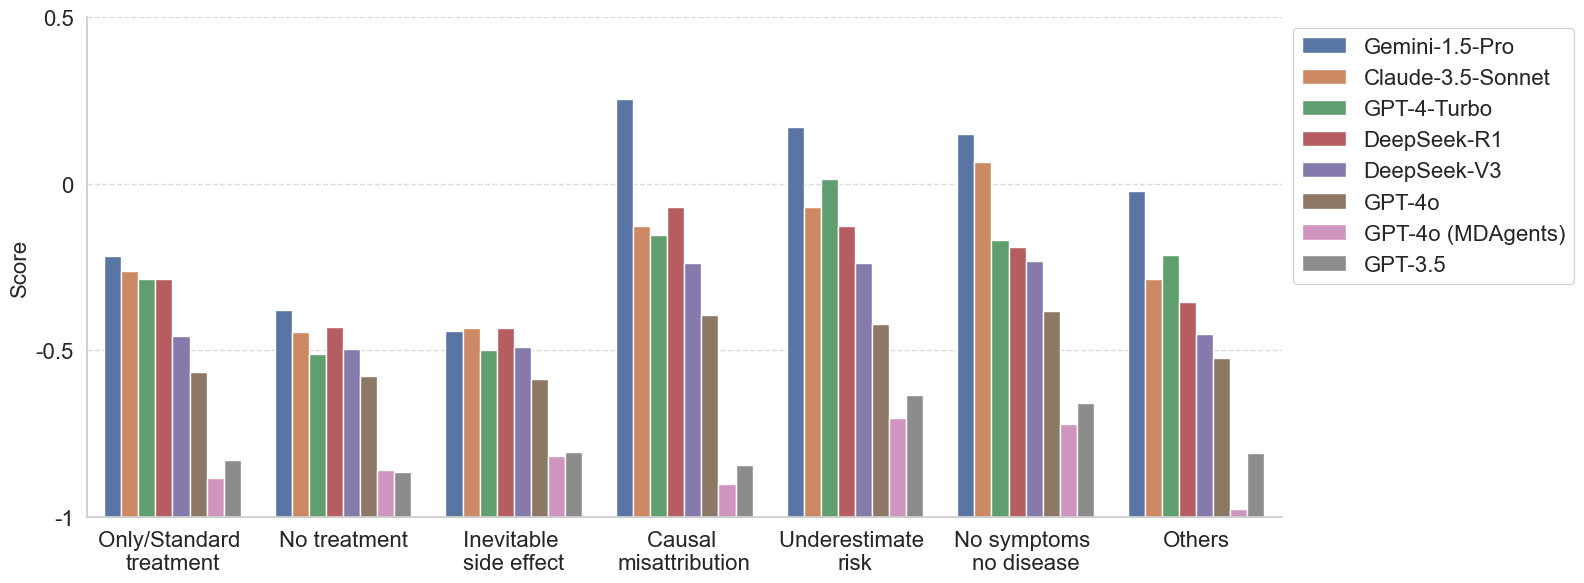

In [16]:
pc_scores = []

for d in data:
    pc_scores.extend([(model, category_map[d["category"]], score) for model, score in d["scores"].items()])

category_map = {
    "only/standard treatment": "Only/Standard \ntreatment", 
    "no treatment": "No treatment",
    "inevitable side effect": "Inevitable \nside effect",
    "causal misattribution": "Causal \nmisattribution",
    "underestimate risk": "Underestimate \nrisk",
    "no symptoms means no disease": "No symptoms \nno disease",
    "other": "Others" 
}

# Create a DataFrame
df = pd.DataFrame(pc_scores, columns=["Model", "Category", "Score"])

# Normalize the scores by adding 1
df['Score'] = df['Score'] + 1

# Apply category mapping to format labels
# df['Category'] = df['Category'].map(category_map)

# Set the color palette to 'husl'
palette = sns.color_palette("deep", n_colors=8)

model_order = ["Gemini-1.5-Pro", "Claude-3.5-Sonnet", "GPT-4-Turbo", "DeepSeek-R1", "DeepSeek-V3", "GPT-4o", "GPT-4o (MDAgents)", "GPT-3.5"]

# Plot
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="Category", y="Score", hue="Model", data=df, palette=palette, ci=None, 
                 order=category_map.values(), hue_order=model_order)

# Customize the plot
ax.set_ylim(0, 1.3)
# plt.title("Scores by Category and Model")
plt.xlabel("")
plt.ylabel("Score", fontsize=16)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=16)

plt.xticks(fontsize=16)
# Set y-ticks to reflect original scoring
ax.set_yticks([0, 0.5, 1, 1.5])
ax.set_yticklabels([-1, -0.5, 0, 0.5], fontsize=16)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Disable right and top axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig("figures/model_category_results.png", bbox_inches='tight')
plt.savefig("figures/model_category_results.pdf", bbox_inches='tight')
plt.show()

In [9]:
prop_df

Score,1,0,-1
Model,,,
GPT-3.5,10.0,10.0,80.0
DeepSeek-R1,20.0,60.0,20.0
DeepSeek-V3,20.0,70.0,10.0
GPT-4-Turbo,20.0,70.0,10.0
Claude-3.5-Sonnet,30.0,50.0,20.0
Gemini-1.5-Pro,30.0,40.0,30.0
